Import Libraries

In [24]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import keras_tuner
from pandas import read_csv
import math
import h5py
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.layers.core import Dense, Activation, Dropout
from scipy.signal import savgol_filter
from keras import backend as K
from keras.optimizers import Adam
import tensorflow as tf
import scipy.stats as stats

Load Data

In [25]:
df = pandas.read_csv('ercot.csv')
df['Datetime'] = pandas.to_datetime(df['Unnamed: 0'])
df = df.drop('Unnamed: 0', axis=1)
df = df.set_index('Datetime')
df = df.resample('D').mean()
df

,COAST
Datetime,
2016-01-01,9733.736857
2016-01-02,9967.949162
2016-01-03,9409.771088
2016-01-04,10257.882329
2016-01-05,10532.679773
...,...
2020-12-27,10252.197429
2020-12-28,10735.672388
2020-12-29,10741.396777


<AxesSubplot:xlabel='Datetime'>

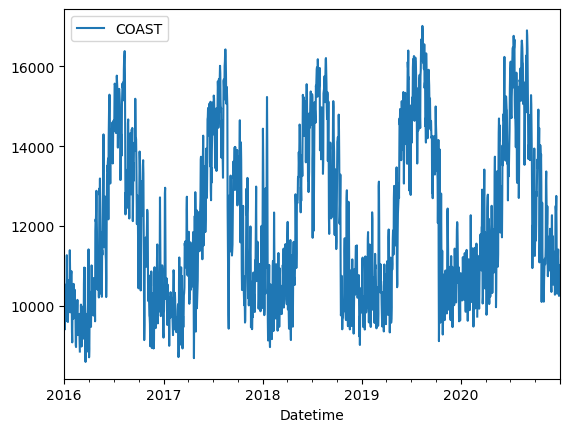

In [26]:
df.plot()

Data Processing

<AxesSubplot:xlabel='Datetime'>

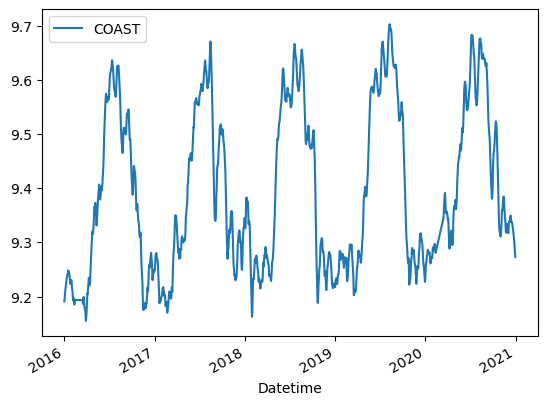

In [27]:
window_size = 30
polynomial_degree = 2
smoothed_data = savgol_filter(df['COAST'], window_size, polynomial_degree)
filtered_data = pandas.DataFrame({'COAST': smoothed_data}, index=df.index)
filtered_data['COAST'] = np.log(filtered_data['COAST'])
filtered_data = filtered_data.dropna()
filtered_data.plot()

<AxesSubplot:xlabel='Datetime'>

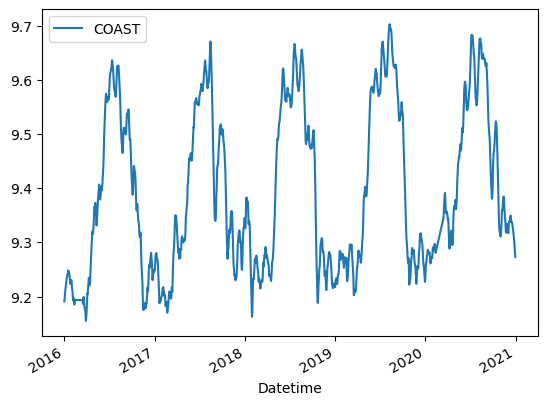

In [28]:
filtered_data.plot()

LSTM Model formulation

In [29]:
 # convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

all_y = filtered_data.values
dataset=all_y.reshape(-1, 1)

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets, 30% test data, 70% training data
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1, timestep 240
look_back = 150
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


learning_rate = 0.0005
model = Sequential()
model.add(LSTM(128, input_shape=(1, look_back)))
model.add(Dropout(0.1))
model.add(Dense(1))
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='mse', optimizer=optimizer)

# Train the model
history = model.fit(trainX, trainY, epochs=500, batch_size=240, verbose=1, validation_data=(testX, testY))
# model.save('C:\\Users\\Dell\\Desktop\\lstm_ci.h5')

Epoch 1/500
5/5 [==============================] - 4s 186ms/step - loss: 0.1715 - val_loss: 0.1018
Epoch 2/500
5/5 [==============================] - 0s 21ms/step - loss: 0.1009 - val_loss: 0.0571
Epoch 3/500
5/5 [==============================] - 0s 21ms/step - loss: 0.0477 - val_loss: 0.0233
Epoch 4/500
5/5 [==============================] - 0s 21ms/step - loss: 0.0292 - val_loss: 0.0345
Epoch 5/500
5/5 [==============================] - 0s 21ms/step - loss: 0.0231 - val_loss: 0.0166
Epoch 6/500
5/5 [==============================] - 0s 21ms/step - loss: 0.0185 - val_loss: 0.0131
Epoch 7/500
5/5 [==============================] - 0s 21ms/step - loss: 0.0179 - val_loss: 0.0127
Epoch 8/500
5/5 [==============================] - 0s 22ms/step - loss: 0.0135 - val_loss: 0.0165
Epoch 9/500
5/5 [==============================] - 0s 22ms/step - loss: 0.0132 - val_loss: 0.0115
Epoch 10/500
5/5 [==============================] - 0s 22ms/step - loss: 0.0113 - val_loss: 0.0077
Epoch 11/500
5/5 [

Epoch 84/500
5/5 [==============================] - 0s 23ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 85/500
5/5 [==============================] - 0s 23ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 86/500
5/5 [==============================] - 0s 22ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 87/500
5/5 [==============================] - 0s 22ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 88/500
5/5 [==============================] - 0s 24ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 89/500
5/5 [==============================] - 0s 23ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 90/500
5/5 [==============================] - 0s 25ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 91/500
5/5 [==============================] - 0s 23ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 92/500
5/5 [==============================] - 0s 25ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 93/500
5/5 [==============================] - 0s 22ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 94/5

Epoch 166/500
5/5 [==============================] - 0s 21ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 167/500
5/5 [==============================] - 0s 21ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 168/500
5/5 [==============================] - 0s 21ms/step - loss: 0.0011 - val_loss: 9.0637e-04
Epoch 169/500
5/5 [==============================] - 0s 21ms/step - loss: 0.0011 - val_loss: 7.7769e-04
Epoch 170/500
5/5 [==============================] - 0s 22ms/step - loss: 0.0012 - val_loss: 7.9425e-04
Epoch 171/500
5/5 [==============================] - 0s 25ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 172/500
5/5 [==============================] - 0s 21ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 173/500
5/5 [==============================] - 0s 22ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 174/500
5/5 [==============================] - 0s 22ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 175/500
5/5 [==============================] - 0s 23ms/step - loss: 0.0012 - val_l

5/5 [==============================] - 0s 29ms/step - loss: 8.9466e-04 - val_loss: 0.0010
Epoch 245/500
5/5 [==============================] - 0s 26ms/step - loss: 9.1060e-04 - val_loss: 0.0010
Epoch 246/500
5/5 [==============================] - 0s 24ms/step - loss: 9.0392e-04 - val_loss: 0.0012
Epoch 247/500
5/5 [==============================] - 0s 28ms/step - loss: 8.5848e-04 - val_loss: 0.0013
Epoch 248/500
5/5 [==============================] - 0s 25ms/step - loss: 8.1688e-04 - val_loss: 0.0011
Epoch 249/500
5/5 [==============================] - 0s 25ms/step - loss: 8.1073e-04 - val_loss: 8.6835e-04
Epoch 250/500
5/5 [==============================] - 0s 26ms/step - loss: 7.8391e-04 - val_loss: 7.9685e-04
Epoch 251/500
5/5 [==============================] - 0s 24ms/step - loss: 8.7215e-04 - val_loss: 8.1838e-04
Epoch 252/500
5/5 [==============================] - 0s 25ms/step - loss: 8.2692e-04 - val_loss: 7.1948e-04
Epoch 253/500
5/5 [==============================] - 0s 24ms/s

5/5 [==============================] - 0s 21ms/step - loss: 7.5226e-04 - val_loss: 7.5784e-04
Epoch 321/500
5/5 [==============================] - 0s 21ms/step - loss: 7.1710e-04 - val_loss: 9.3687e-04
Epoch 322/500
5/5 [==============================] - 0s 22ms/step - loss: 7.8455e-04 - val_loss: 8.2054e-04
Epoch 323/500
5/5 [==============================] - 0s 21ms/step - loss: 6.8079e-04 - val_loss: 8.0921e-04
Epoch 324/500
5/5 [==============================] - 0s 22ms/step - loss: 7.1996e-04 - val_loss: 6.9121e-04
Epoch 325/500
5/5 [==============================] - 0s 22ms/step - loss: 7.5646e-04 - val_loss: 5.7156e-04
Epoch 326/500
5/5 [==============================] - 0s 23ms/step - loss: 7.6769e-04 - val_loss: 6.3234e-04
Epoch 327/500
5/5 [==============================] - 0s 23ms/step - loss: 7.2080e-04 - val_loss: 5.9592e-04
Epoch 328/500
5/5 [==============================] - 0s 22ms/step - loss: 8.3704e-04 - val_loss: 4.9199e-04
Epoch 329/500
5/5 [=======================

5/5 [==============================] - 0s 25ms/step - loss: 5.7782e-04 - val_loss: 5.5462e-04
Epoch 397/500
5/5 [==============================] - 0s 25ms/step - loss: 6.2358e-04 - val_loss: 6.3290e-04
Epoch 398/500
5/5 [==============================] - 0s 24ms/step - loss: 6.2048e-04 - val_loss: 7.3094e-04
Epoch 399/500
5/5 [==============================] - 0s 23ms/step - loss: 6.1564e-04 - val_loss: 7.8186e-04
Epoch 400/500
5/5 [==============================] - 0s 25ms/step - loss: 5.8766e-04 - val_loss: 7.0832e-04
Epoch 401/500
5/5 [==============================] - 0s 23ms/step - loss: 6.2353e-04 - val_loss: 6.3808e-04
Epoch 402/500
5/5 [==============================] - 0s 24ms/step - loss: 6.0545e-04 - val_loss: 5.6770e-04
Epoch 403/500
5/5 [==============================] - 0s 26ms/step - loss: 5.7844e-04 - val_loss: 9.2092e-04
Epoch 404/500
5/5 [==============================] - 0s 28ms/step - loss: 6.3109e-04 - val_loss: 7.5766e-04
Epoch 405/500
5/5 [=======================

5/5 [==============================] - 0s 24ms/step - loss: 5.9606e-04 - val_loss: 5.8985e-04
Epoch 473/500
5/5 [==============================] - 0s 23ms/step - loss: 6.0339e-04 - val_loss: 3.8885e-04
Epoch 474/500
5/5 [==============================] - 0s 23ms/step - loss: 6.3574e-04 - val_loss: 4.4054e-04
Epoch 475/500
5/5 [==============================] - 0s 22ms/step - loss: 6.3273e-04 - val_loss: 7.5951e-04
Epoch 476/500
5/5 [==============================] - 0s 24ms/step - loss: 7.2291e-04 - val_loss: 0.0011
Epoch 477/500
5/5 [==============================] - 0s 24ms/step - loss: 5.8226e-04 - val_loss: 0.0014
Epoch 478/500
5/5 [==============================] - 0s 26ms/step - loss: 6.0216e-04 - val_loss: 8.8839e-04
Epoch 479/500
5/5 [==============================] - 0s 24ms/step - loss: 5.6024e-04 - val_loss: 8.0180e-04
Epoch 480/500
5/5 [==============================] - 0s 26ms/step - loss: 5.2356e-04 - val_loss: 6.2509e-04
Epoch 481/500
5/5 [==============================]

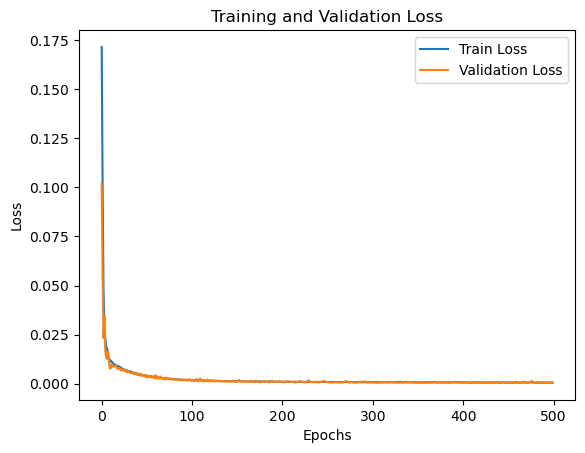

In [30]:
# Extract loss values from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training loss and validation loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Monte Carlo Dropout - Confidence Interval Generation

In [31]:
def run_monte_carlo_dropout(model, X, n_samples=30):
    """
    Run Monte Carlo Dropout for making predictions.

    Parameters:
    model (keras.Model): The trained LSTM model.
    X (numpy.array): Input data for predictions.
    n_samples (int): Number of samples to draw.

    Returns:
    numpy.array: Mean predictions.
    numpy.array: Standard deviation of predictions.
    """
    predictions = np.zeros((n_samples, X.shape[0], X.shape[1]))

    for i in range(n_samples):
        predictions[i] = model.predict(X)

    mean_predictions = np.mean(predictions, axis=0)
    std_predictions = np.std(predictions, axis=0)

    return mean_predictions, std_predictions

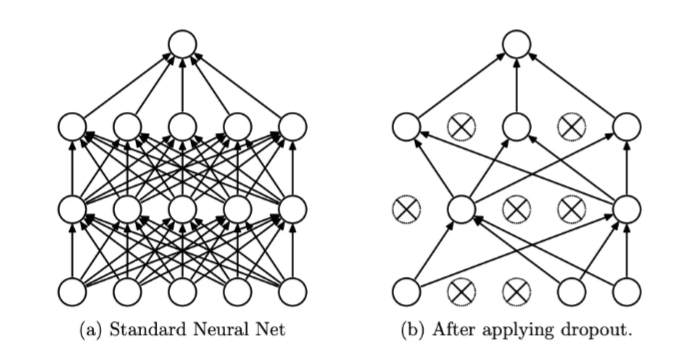

In [32]:
n_samples = 30  # Number of MC Dropout samples
mean_predictions, std_predictions= run_monte_carlo_dropout(model, testX, n_samples)

12/12 [==============================] - 0s 4ms/step


In [33]:
mean_predictions = scaler.inverse_transform(mean_predictions.reshape(-1, 1)).flatten()
mean_predictions = np.exp(mean_predictions)
std_predictions = scaler.inverse_transform(std_predictions.reshape(-1, 1)).flatten()
std_predictions = np.exp(std_predictions) 

In [34]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainPredict = np.exp(trainPredict)
trainY = scaler.inverse_transform([trainY])
trainY = np.exp(trainY)
testPredict = scaler.inverse_transform(testPredict)
testPredict = np.exp(testPredict)
testY = scaler.inverse_transform([testY])
testY = np.exp(testY)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

12/12 [==============================] - 0s 3ms/step
Train Score: 100.71 RMSE
Test Score: 144.46 RMSE


In [35]:
# Plot original data, mean predictions, and confidence intervals
# plt.plot(testY.flatten(), label='True Values', color= 'blue')
# plt.plot(mean_predictions.flatten(), label='Mean Predictions', color = 'red')
# plt.fill_between(
#      range(len(mean_predictions.flatten())),
#      mean_predictions.flatten() - 1.44 * std_predictions.flatten(),
#      mean_predictions.flatten() + 1.44 * std_predictions.flatten(),
#      color='blue', alpha=0.3, label='85% Confidence Intervals'
# )
# plt.fill_between(
#      range(len(mean_predictions.flatten())),
#      mean_predictions.flatten() - 1.96 * std_predictions.flatten(),
#      mean_predictions.flatten() + 1.96 * std_predictions.flatten(),
#      color='red', alpha=0.3, label='95% Confidence Intervals'
# )
# plt.legend()
# plt.show()

1 month future forecast based on trained Model

In [36]:
last_sequence = dataset[-look_back:]
num_predictions = 30

predicted_values = []

for _ in range(num_predictions):
    last_sequence_reshaped = np.reshape(last_sequence, (1, 1, look_back))
    predicted_value = model.predict(last_sequence_reshaped)
    predicted_values.append(predicted_value[0, 0])
    last_sequence = np.append(last_sequence[1:], predicted_value[0])

# Invert the predictions back to the original scale
predicted_values = scaler.inverse_transform([predicted_values])
predicted_values = np.exp(predicted_values)
print(predicted_values)

1/1 [==============================] - 0s 48ms/step
[[10651.96742363 10637.10011144 10612.80850081 10597.54546892
  10602.78084285 10612.8031223  10627.15348103 10646.44442138
  10649.34266546 10631.31750552 10606.01067906 10598.88417609
  10606.38433943 10623.74995181 10655.10110821 10674.67461685
  10680.2876924  10690.30633731 10712.55023758 10752.31316884
  10806.76197921 10864.13869402 10908.78646437 10930.12899956
  10955.74118359 11000.43108518 11054.06968386 11118.24070296
  11184.83163561 11233.93500966]]


In [37]:
# Generate a date range for the future predictions
start_date = pandas.to_datetime(df.index[-1]) + pandas.DateOffset(days=1)  # Assuming the last date in dt is the latest date
end_date = start_date + pandas.DateOffset(days=num_predictions-1)
future_dates = pandas.date_range(start=start_date, end=end_date)
predicted_values = np.reshape(predicted_values, (num_predictions,))
predicted_df = pandas.DataFrame(predicted_values, index=future_dates, columns=['Predicted'])
predicted_df

,Predicted
2021-01-01,10651.967424
2021-01-02,10637.100111
2021-01-03,10612.808501
2021-01-04,10597.545469
2021-01-05,10602.780843
2021-01-06,10612.803122
2021-01-07,10627.153481
2021-01-08,10646.444421
2021-01-09,10649.342665
2021-01-10,10631.317506


Model Performance Validation

In [38]:
rmse = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('RMSE:', rmse)
mape = np.mean(np.abs((testY[0] -testPredict[:,0]) / testY[0])) * 100
print('MAPE:', mape)
r2 = r2_score(testY[0], testPredict[:,0])
print('R-squared:', r2)

def mda(actual, predicted):
    actual_direction = np.sign(np.diff(actual))
    predicted_direction = np.sign(np.diff(predicted))
    correct_directions = np.sum(actual_direction == predicted_direction)
    mda_value = correct_directions / (len(actual_direction) - 1)
    return mda_value

mda_value = mda(testY[0], testPredict[:,0])
print('MDA:', mda_value)

RMSE: 144.46345682778892
MAPE: 0.859622286255861
R-squared: 0.9932315005071096
MDA: 0.753968253968254


Confidence Interval Formulation

In [39]:
def calculate_confidence_interval(predictions, standard_error, confidence_level=0.95):
  """Calculates the confidence interval for a given set of predictions.

  Args:
    predictions: A list of predictions.
    standard_error: The standard error of the predictions.
    confidence_level: The desired confidence level.

  Returns:
    A list of confidence intervals, where each confidence interval is a tuple of
    (lower bound, upper bound).
  """

  z_score = stats.norm.ppf(1 - (1 - confidence_level) / 2)
  confidence_intervals = []
  for prediction in predictions:
    lower_bound = prediction - z_score * standard_error
    upper_bound = prediction + z_score * standard_error
    confidence_intervals.append((lower_bound, upper_bound))
  return confidence_intervals

In [40]:
std_p = np.std(predicted_values)
std_error = std_p/np.sqrt(num_predictions)
confidence_intervals = calculate_confidence_interval(predicted_values,std_error, 0.95)

In [41]:
df = pandas.DataFrame(confidence_intervals, columns=['lower_bound', 'upper_bound'])
df.index = predicted_df.index

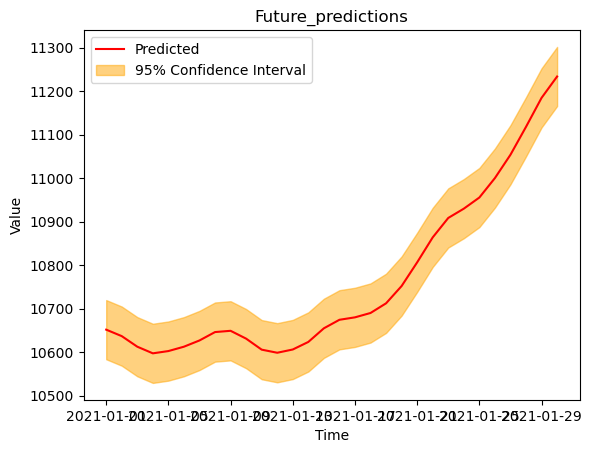

In [42]:
#plt.plot(dt.index, np.exp(filtered_data), color='blue', label='Historical')
plt.plot(predicted_df.index, predicted_df['Predicted'], color='red', label='Predicted')
plt.fill_between(df.index, df['lower_bound'], df['upper_bound'], color='orange', alpha=0.5, label='95% Confidence Interval')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Future_predictions')
plt.legend()
plt.show()

In [43]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               142848    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 142,977
Trainable params: 142,977
Non-trainable params: 0
_________________________________________________________________
